In [26]:
from typing import TypedDict, Annotated, Optional
import json

from dotenv import load_dotenv
import os

from langgraph.graph import add_messages, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

from uuid import uuid4

In [8]:
load_dotenv()

True

#### Test Model

In [9]:
model = ChatOpenAI(model="gpt-4o")

In [10]:
response = model.invoke("Hi how are you")
response

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 11, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Byd7R2nUtimLSYcY31Z32LXp9rZ6x', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--baae3287-47a6-46f9-be5e-b79c7249a5b2-0', usage_metadata={'input_tokens': 11, 'output_tokens': 29, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### Test Tavily

In [11]:
search_tool = TavilySearchResults(max_results=4)

response = search_tool.invoke("who won women euro 2025")
response

C:\Users\acer\AppData\Local\Temp\ipykernel_7780\2118249668.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


[{'title': "Football, UEFA Women's EURO 2025 final: England come from ...",
  'url': 'https://www.olympics.com/en/news/uefa-womens-euro-2025-final-england-vs-spain-live-updates',
  'content': "By Nischal Schwager-Patel Updated on 27 July 2025 18:50 GMT+0 12 min read\n\nEngland are the champions of Europe, defeating world champions Spain in the UEFA Women’s EURO 2025 final.\n\nAfter 120 minutes of tense football on Sunday (27 July), Chloe Kelly scored the decisive spot kick in the penalty shootout, as England won 3-1 on penalties after a 1-1 draw in normal time at St. Jakob-Park. [...] UEFA Women’s EURO 2025 final: England come from behind to beat Spain in penalty shootout - as it happened\n=========================================================================================================\n\nRelive how England became the champions of Europe once again, defeating world champions Spain in the UEFA Women’s EURO 2025 final.\n\nImage 2: England celebrate penalty shootout victory in the

In [12]:
tools = [search_tool]

#### Memory Saver

In [13]:
memory = MemorySaver()

In [14]:
llm_with_tools = model.bind_tools(tools=tools)

In [16]:
response = llm_with_tools.invoke("who won women euro 2025")

In [17]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nh4YkBaUnw7lKeW0r6dIgCqr', 'function': {'arguments': '{"query":"women euro 2025 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 86, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BydAxozdujkrJwQ5jEONxChfhH9Rm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e34fc25d-a851-4a26-8688-2b57c6ed9166-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'women euro 2025 winner'}, 'id': 'call_nh4YkBaUnw7lKeW0r6dIgCqr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_to

In [23]:
response.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'women euro 2025 winner'},
  'id': 'call_nh4YkBaUnw7lKeW0r6dIgCqr',
  'type': 'tool_call'}]

#### Building Graph

In [24]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

In [20]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [21]:
async def model(state: AgentState):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result],
    }

In [42]:
async def tool_router(state: AgentState):
    latest_message = state["messages"][-1]
    
    if (hasattr(latest_message, "tool_calls") and len(latest_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END

In [43]:
async def tool_node(state: AgentState):
    """Tool node to execute the tool that the llm call"""
    tool_calls = state["messages"][-1].tool_calls
    
    # initialize the list to store tool messages
    tool_messages = []
    
    # process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # handle the search tool
        if tool_name == "tavily_search_results_json":
            # execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            # create a tool message for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
            
    # add the tool message to the state (add_messages le automatic gardinxa)
    return {
        "messages": tool_messages
    }

In [44]:
graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)

graph.add_edge(START, "model")
graph.add_conditional_edges("model", tool_router, {
    "tool_node": "tool_node",
    END: END
})
graph.add_edge("tool_node", "model")

workflow = graph.compile(checkpointer=memory)

#### Visualize Graph

In [45]:
from IPython.display import display, Image

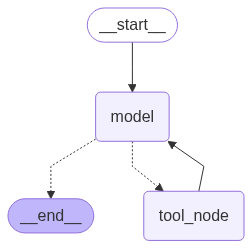

In [46]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [50]:
config = {
    "configurable":  {
        "thread_id": "100"
    }
}

In [51]:
response = await workflow.ainvoke({
    "messages": [HumanMessage(content="Hi I am Harrindar")]
}, config=config)

In [52]:
response

{'messages': [HumanMessage(content='Hi I am Harrindar', additional_kwargs={}, response_metadata={}, id='c6e1af45-87be-4636-bba0-df41a08b7b86'),
  AIMessage(content='Hello Harrindar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 85, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BydcFxpy7iAbnPU8xiH6iawXA35ED', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--17340e3c-5621-4e74-9feb-7b6cf172958a-0', usage_metadata={'input_tokens': 85, 'output_tokens': 13, 'total_tokens': 98, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [ ]:
config = {
    "configurable":  {
        "thread_id": "100"
    }
}

In [54]:
response = await workflow.ainvoke({
    "messages": [HumanMessage(content="who won women euro 2025")]
}, config=config)

In [55]:
response

{'messages': [HumanMessage(content='Hi I am Harrindar', additional_kwargs={}, response_metadata={}, id='c6e1af45-87be-4636-bba0-df41a08b7b86'),
  AIMessage(content='Hello Harrindar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 85, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BydcFxpy7iAbnPU8xiH6iawXA35ED', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--17340e3c-5621-4e74-9feb-7b6cf172958a-0', usage_metadata={'input_tokens': 85, 'output_tokens': 13, 'total_tokens': 98, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage

In [57]:
response = await workflow.ainvoke({
    "messages": [HumanMessage(content="what is my name")]
}, config=config)
response["messages"][-1].content

'Your name is Harrindar.'

In [58]:
response

{'messages': [HumanMessage(content='Hi I am Harrindar', additional_kwargs={}, response_metadata={}, id='c6e1af45-87be-4636-bba0-df41a08b7b86'),
  AIMessage(content='Hello Harrindar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 85, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BydcFxpy7iAbnPU8xiH6iawXA35ED', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--17340e3c-5621-4e74-9feb-7b6cf172958a-0', usage_metadata={'input_tokens': 85, 'output_tokens': 13, 'total_tokens': 98, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage

#### Streaming Data

In [ ]:
async for event in workflow.astream_events(
    {
        "messages": [HumanMessage(content="what was my first question")]
    },
    config={
        "configurable": {
            "thread_id": "10000"
        }
        },
    version="v2"
):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='what was my first question', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'fc42785b-88b6-4d96-9c40-b7dece4cd6f9', 'metadata': {'thread_id': '10000'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='what was my first question', additional_kwargs={}, response_metadata={}, id='ee44f0f1-a131-4597-807a-9f75bbb73f43')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': 'f6b4bed9-8238-4f6c-94a5-a0a1ee2afb4c', 'metadata': {'thread_id': '10000', 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:ecadb879-2dcd-2884-b5e7-5155d0654e0d'}, 'parent_ids': ['fc42785b-88b6-4d96-9c40-b7dece4cd6f9']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='what was my first 

In [66]:
async for event in workflow.astream_events(
    {
        "messages": [HumanMessage(content="Hey")]
    },
    config={
        "configurable": {
            "thread_id": "100000"
        }
        },
    version="v2"
):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

Hello! How can I assist you today?

In [67]:
async for event in workflow.astream_events(
    {
        "messages": [HumanMessage(content="write 100 word story")]
    },
    config={
        "configurable": {
            "thread_id": "100000"
        }
        },
    version="v2"
):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

Amelia had always been a dreamer, her head filled with possibilities as endless as the night sky. One chilly autumn evening, she wandered into the old library, attracted by whispers of forgotten tales. Dust danced in the golden light as she pulled a book from the shelf. As she read, the words lifted from the pages, swirling around her in a whirlwind of magic. Suddenly, she found herself in a world of dragons and enchanted forests. The characters welcomed her as one of their own. For the first time, Amelia wasn't merely dreaming—she was living the adventure she'd always imagined.